# Evaulate Fine-Tuned Model

In [1]:
import os
import sys
import json
import random

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset
from unsloth import FastLanguageModel
from trl import SFTConfig, SFTTrainer
from transformers import DataCollatorForSeq2Seq


MODEL_NAME = "unsloth/Llama-3.2-1B-Instruct"
print(MODEL_NAME)
# Training settings
# llama3.2 support 128k tokens
MAX_SEQ_LENGTH = 4096 # Choose any! We auto support RoPE Scaling internally!
LOAD_IN_4BIT = False # Use 4bit quantization to reduce memory usage. Can be False.


WANDB_PROJECT = "BMW-Llama-3.2-1B"
WANDB_ENTITY = None  
WANDB_RUN_NAME = "BMW-Llama-3.2-1B-2000Articles2"

TRAIN_CHAT_DATA_FILE_NAME = '../datasets/chat_data_2000/train_chat.jsonl'
VAL_CHAT_DATA_FILE_NAME = '../datasets/chat_data_2000/val_chat.jsonl'
TEST_CHAT_DATA_FILE_NAME = '../datasets/chat_data_2000/test_chat.jsonl'

# Set checkpoint directory
CHECKPOINT_DIR = f"../checkpoints/{MODEL_NAME}"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Use the checkpoint_dir variable to save models
LORA_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "lora_model")
MERGED_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "merged_model")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
unsloth/Llama-3.2-1B-Instruct


In [2]:
dataset_test = load_dataset("json", data_files=TEST_CHAT_DATA_FILE_NAME, split="train")
test_ds = Dataset.from_list(dataset_test)

print("HuggingFace Chat Datasets:")
print(f"  Test: {test_ds}")

HuggingFace Chat Datasets:
  Test: Dataset({
    features: ['messages'],
    num_rows: 787
})


In [3]:
test_model, test_tokenizer = FastLanguageModel.from_pretrained(
    model_name = MERGED_MODEL_PATH,
    max_seq_length = 10240,
    dtype = None,
    load_in_4bit = False,
)

# Enable inference mode
FastLanguageModel.for_inference(test_model)
print("✓ Model loaded successfully for inference!")

==((====))==  Unsloth 2026.1.2: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    NVIDIA GeForce RTX 5090. Num GPUs = 1. Max memory: 31.348 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✓ Model loaded successfully for inference!


In [4]:
### Test on a few examples using the chat format

def generate_response_from_messages(model, tokenizer, messages, max_new_tokens=512):
    """Generate response for a given list of messages (chat format)."""
    # Use only system and user messages for input (exclude assistant response)
    input_messages = [msg for msg in messages if msg["role"] != "assistant"]
    
    # Apply chat template
    prompt = tokenizer.apply_chat_template(
        input_messages,
        tokenize = False,
        add_generation_prompt = True  # Add generation prompt for inference
    )
    
    # Tokenize
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    
    # Generate
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    
    # Decode only the generated part (remove the prompt)
    generated_text = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return generated_text.strip()

In [5]:


# Test on a few examples from test_chat_ds (chat format)
print("=" * 80)
print("Testing on a few examples from test chat dataset")
print("=" * 80)

num_test_examples = 5
for i in range(min(num_test_examples, len(test_ds))):
    example = test_ds[i]
    messages = example["messages"]
    
    # Extract user message content
    user_content = next((msg["content"] for msg in messages if msg["role"] == "user"), "")
    expected_output = next((msg["content"] for msg in messages if msg["role"] == "assistant"), "")
    
    print(f"\n{'='*80}")
    print(f"Example {i+1}/{num_test_examples}")
    print(f"{'='*80}")
    print(f"\n📝 User Message: {user_content[:300]}..." if len(user_content) > 300 else f"\n📝 User Message: {user_content}")
    
    # Generate response
    print("\n🤖 Generating response...")
    generated_output = generate_response_from_messages(test_model, test_tokenizer, messages)
    
    print(f"\n✅ Expected Output: {expected_output}")
    print(f"\n🤖 Generated Output: {generated_output}")
    print(f"\n{'─'*80}")


Testing on a few examples from test chat dataset

Example 1/5

📝 User Message: Summarize the following BMW news article in a concise way.

There's something magical about waking up in Namibia, even more so when it's under the roar of lions, ready for battle - or at least, that's what it felt like listening to the nearly 80 boxer engines revving up as they emerged from the vall...

🤖 Generating response...

✅ Expected Output: Recap of Day 2. Location: Spitzkoppe, Namibia Weather: Sunny, 12°C – 29 °C Course: 184km: Ai Aiba – Schwarze Spitzkoppe – Spitzkoppe Terrain types: Tarmac 0km, off-road 184km Tests: SP1: Flying Boxer, SP2: The SENA Rock Challenge Top three teams male: 1. South Africa, 2. Germany, 3. International Team Top three teams female: 1. Germany, Japan, 3. Benelux

🤖 Generated Output: There's something magical about waking up in Namibia, even more so when it's under the roar of lions, ready for battle - or at least, that's what it felt like listening to the nearly 80 boxer e

In [6]:
### Batch testing on test chat dataset

from tqdm import tqdm
import time

print(f"Testing on {len(test_ds)} examples from test chat dataset...")
print("This may take a while...\n")

results = []
start_time = time.time()

# Test on all examples (or a subset)
test_subset_size = len(test_ds)  # Change this to test on fewer examples, e.g., 50
test_indices = range(min(test_subset_size, len(test_ds)))

for idx in tqdm(test_indices, desc="Testing"):
    example = test_ds[idx]
    messages = example["messages"]
    
    # Extract user and expected assistant messages
    user_content = next((msg["content"] for msg in messages if msg["role"] == "user"), "")
    expected_output = next((msg["content"] for msg in messages if msg["role"] == "assistant"), "")
    
    try:
        generated_output = generate_response_from_messages(test_model, test_tokenizer, messages)
        
        results.append({
            "index": idx,
            "user_message": user_content,
            "expected": expected_output,
            "generated": generated_output,
            "success": True
        })
    except Exception as e:
        results.append({
            "index": idx,
            "user_message": user_content,
            "expected": expected_output,
            "generated": f"Error: {str(e)}",
            "success": False
        })

elapsed_time = time.time() - start_time
print(f"\n✓ Testing completed in {elapsed_time:.2f} seconds")
print(f"✓ Tested {len(results)} examples")
print(f"✓ Success rate: {sum(1 for r in results if r['success'])}/{len(results)}")

RESULTS_FILE = os.path.join(CHECKPOINT_DIR, "test_results.json")
with open(RESULTS_FILE, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)
print(f"\n✓ Results saved to: {RESULTS_FILE}")

Testing on 787 examples from test chat dataset...
This may take a while...



Testing: 100%|██████████| 787/787 [01:43<00:00,  7.63it/s]


✓ Testing completed in 103.16 seconds
✓ Tested 787 examples
✓ Success rate: 787/787

✓ Results saved to: ../checkpoints/unsloth/Llama-3.2-1B-Instruct/test_results.json


In [7]:
# Import evaluation functions from chatbmw package
from chatbmw import (
    evaluate_by_task,
    save_metrics,
    print_summary,
    assess_quality,
    QUALITY_THRESHOLDS,
)

# Run comprehensive evaluation on all test results
print("🚀 Running comprehensive evaluation...")
print(f"   Evaluating {len(results)} test samples\n")

# Evaluate by task (computes ROUGE, BERTScore, classification metrics, etc.)
# Set compute_bertscore=False for faster evaluation (skips semantic similarity)
metrics = evaluate_by_task(results, compute_bertscore=True, verbose=True)

# Print summary and assess quality
print_summary(metrics)

# Assess quality based on predefined thresholds
quality_ratings = assess_quality(metrics)
print("\n📋 Quality Assessment:")
for task, rating in quality_ratings.items():
    print(f"  {task}: {rating}")

🚀 Running comprehensive evaluation...
   Evaluating 787 test samples


Task: SUMMARIZATION (197 samples)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 ROUGE Scores:
  ROUGE-1 F1: 0.5557
  ROUGE-2 F1: 0.4463
  ROUGE-L F1: 0.5005

📊 BERTScore (Semantic Similarity):
  Precision: 0.9137
  Recall: 0.9124
  F1: 0.9127

📊 Length Metrics:
  Avg Prediction Length: 43.9 words
  Avg Reference Length: 44.6 words
  Length Ratio: 1.20

Task: TITLE_GENERATION (273 samples)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 ROUGE Scores:
  ROUGE-1 F1: 0.6253
  ROUGE-2 F1: 0.4856
  ROUGE-L F1: 0.5628

📊 BERTScore (Semantic Similarity):
  Precision: 0.9322
  Recall: 0.9248
  F1: 0.9283

📊 Length Metrics:
  Avg Prediction Length: 10.6 words
  Avg Reference Length: 12.2 words
  Length Ratio: 0.99

Task: TAG_EXTRACTION (174 samples)

📊 Tag Extraction Metrics:
  Exact Match: 0.3448
  Jaccard Similarity: 0.5584
  Precision: 0.6568
  Recall: 0.6603
  F1: 0.6307

Task: TYPE_CLASSIFICATION (143 samples)

📊 Classification Metrics:
  Accuracy: 0.8811 (126/143)

  Class Distribution: {'press release': 135, 'press kit': 6, 'speech': 2}
  Per-class Accuracy: {'press release': 0.8888888888888888, 'press kit': 0.6666666666666666, 'speech': 1.0}

📊 EVALUATION SUMMARY

SUMMARIZATION:
  ROUGE-L F1: 0.5005
  BERTScore F1: 0.9127

TITLE_GENERATION:
  ROUGE-L F1: 0.5628
  BERTScore F1: 0.9283

TAG_EXTRACTION:
  F1: 0.6307
  Jaccard: 0.5584

TYPE_CLASSIFICATION:
  Accuracy: 0.8811


📋 Quality Assessment:
  summarization: good

In [8]:
# Compute perplexity on the expected outputs
from chatbmw.model.evaluator import compute_perplexity

print("📊 Computing perplexity...")

os.environ['UNSLOTH_RETURN_LOGITS'] = '1'

# Get expected texts for perplexity computation
expected_texts = [r["expected"] for r in results if r["success"]]

perplexity_results = compute_perplexity(
    model=test_model,
    tokenizer=test_tokenizer,
    texts=expected_texts,
    batch_size=4,
)

print(f"\n✓ Perplexity: {perplexity_results['perplexity']:.4f}")
print(f"✓ Avg Loss: {perplexity_results['avg_loss']:.4f}")
print(f"✓ Num Samples: {perplexity_results['num_samples']}")

# Add perplexity to metrics (excluding per-sample values for cleaner output)
metrics["perplexity"] = {
    "perplexity": perplexity_results["perplexity"],
    "avg_loss": perplexity_results["avg_loss"],
    "num_samples": perplexity_results["num_samples"],
}


📊 Computing perplexity...

✓ Perplexity: 310.2822
✓ Avg Loss: 5.7375
✓ Num Samples: 787


In [9]:
# Save evaluation metrics to file
metrics_file = os.path.join(CHECKPOINT_DIR, WANDB_RUN_NAME+"_evaluation_metrics.json")
save_metrics(metrics, metrics_file)

✓ Metrics saved to: ../checkpoints/unsloth/Llama-3.2-1B-Instruct/BMW-Llama-3.2-1B-2000Articles2_evaluation_metrics.json


In [10]:
# Display detailed metrics as a DataFrame for easier viewing
import pandas as pd

# Flatten metrics for display
display_data = []
for task, task_metrics in metrics.items():
    for metric_name, value in task_metrics.items():
        if isinstance(value, (int, float)):
            display_data.append({
                "Task": task,
                "Metric": metric_name,
                "Value": round(value, 4) if isinstance(value, float) else value
            })

metrics_df = pd.DataFrame(display_data)
print("\n📊 All Metrics:")
metrics_df



📊 All Metrics:


,Task,Metric,Value
0,summarization,rouge1_precision,0.5877
1,summarization,rouge1_recall,0.5881
2,summarization,rouge1_fmeasure,0.5557
3,summarization,rouge2_precision,0.4584
4,summarization,rouge2_recall,0.4750
5,summarization,rouge2_fmeasure,0.4463
6,summarization,rougeL_precision,0.5233
7,summarization,rougeL_recall,0.5326
8,summarization,rougeL_fmeasure,0.5005
9,summarization,avg_pred_length,43.8934


# Visualize key metrics

In [11]:
# =============================================================================
# Prepare metrics for visualization (single model with perplexity)
# =============================================================================

# Use the metrics we already computed in this notebook
# This includes perplexity which was added in cell 6

print("📊 Current Model Metrics Summary:")
print(f"Model: {WANDB_RUN_NAME}")
print(f"Training Data: {TRAIN_CHAT_DATA_FILE_NAME}")

# Create a summary of all metrics for visualization
current_metrics = metrics  # metrics dict from cell 5+6

# Set output directory for final evaluation plots
FINAL_EVAL_DIR = CHECKPOINT_DIR

# Display key metrics
for task, task_metrics in current_metrics.items():
    print(f"\n{task.upper()}:")
    for k, v in task_metrics.items():
        if isinstance(v, float):
            print(f"  {k}: {v:.4f}")
        elif isinstance(v, int):
            print(f"  {k}: {v}")


📊 Current Model Metrics Summary:
Model: BMW-Llama-3.2-1B-2000Articles2
Training Data: ../datasets/chat_data_2000/train_chat.jsonl

SUMMARIZATION:
  rouge1_precision: 0.5877
  rouge1_recall: 0.5881
  rouge1_fmeasure: 0.5557
  rouge2_precision: 0.4584
  rouge2_recall: 0.4750
  rouge2_fmeasure: 0.4463
  rougeL_precision: 0.5233
  rougeL_recall: 0.5326
  rougeL_fmeasure: 0.5005
  avg_pred_length: 43.8934
  avg_ref_length: 44.5939
  avg_length_ratio: 1.1994
  std_length_ratio: 1.0268
  bertscore_precision: 0.9137
  bertscore_recall: 0.9124
  bertscore_f1: 0.9127

TITLE_GENERATION:
  rouge1_precision: 0.6777
  rouge1_recall: 0.6148
  rouge1_fmeasure: 0.6253
  rouge2_precision: 0.5231
  rouge2_recall: 0.4785
  rouge2_fmeasure: 0.4856
  rougeL_precision: 0.6074
  rougeL_recall: 0.5550
  rougeL_fmeasure: 0.5628
  avg_pred_length: 10.6264
  avg_ref_length: 12.1758
  avg_length_ratio: 0.9943
  std_length_ratio: 0.5574
  bertscore_precision: 0.9322
  bertscore_recall: 0.9248
  bertscore_f1: 0.9283

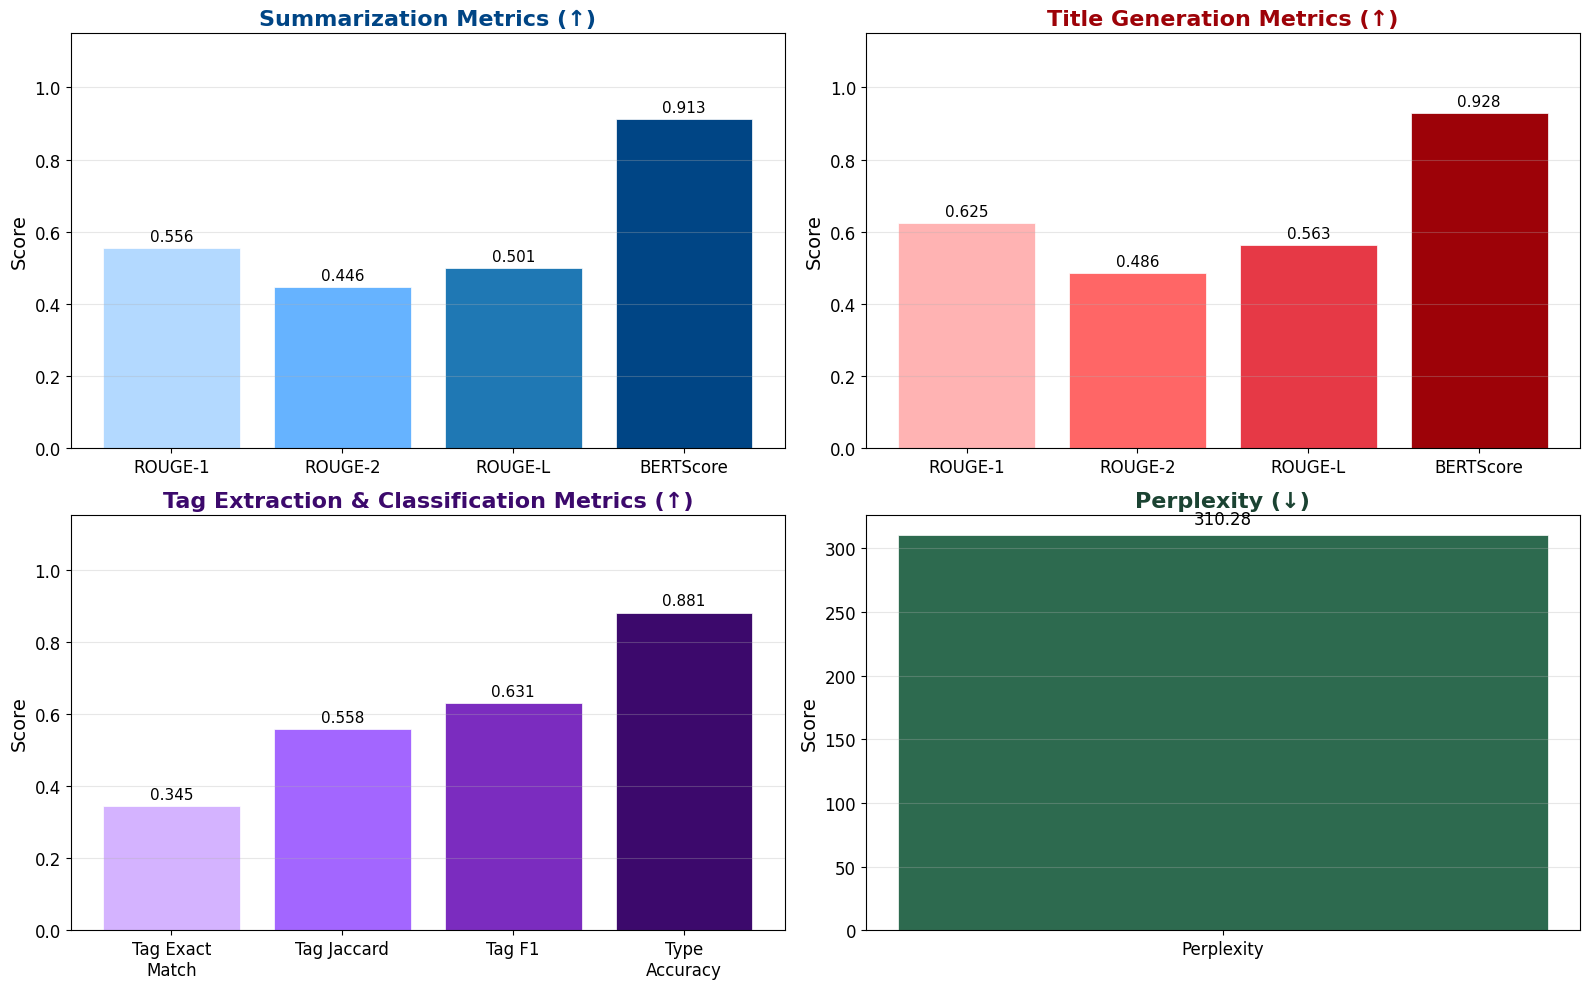

✓ Saved: ../checkpoints/unsloth/Llama-3.2-1B-Instruct/evaluation_metrics_with_perplexity.png


In [12]:
# =============================================================================
# Visualization: Llama-3.2-1B Complete Evaluation with Perplexity
# =============================================================================

# Gradient color palettes for each subplot (light to dark 渐变)
# Blue gradient for Summarization
BLUE_GRADIENT = ["#b3d9ff", "#66b3ff", "#1f78b4", "#004585"]
# Red gradient for Title Generation  
RED_GRADIENT = ["#ffb3b3", "#ff6666", "#e63946", "#9d0208"]
# Purple gradient for Tag & Classification
PURPLE_GRADIENT = ["#d4b3ff", "#a366ff", "#7b2cbf", "#3c096c"]
# Green gradient for Perplexity
GREEN_GRADIENT = ["#b7e4c7", "#52b788", "#2d6a4f", "#1b4332"]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Summarization metrics - Blue gradient (light → dark)
if "summarization" in current_metrics:
    ax = axes[0, 0]
    summ = current_metrics["summarization"]
    keys = ["rouge1_fmeasure", "rouge2_fmeasure", "rougeL_fmeasure", "bertscore_f1"]
    values = [summ.get(k, 0) for k in keys]
    labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore"]
    
    bars = ax.bar(labels, values, color=BLUE_GRADIENT, edgecolor='white', linewidth=0.5)
    ax.set_ylim(0, 1.15)
    ax.set_ylabel('Score', fontsize=14)
    ax.set_title('Summarization Metrics (↑)', fontsize=16, fontweight='bold', color=BLUE_GRADIENT[-1])
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='both', labelsize=12)
    
    for bar, val in zip(bars, values):
        ax.annotate(f'{val:.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=11)

# 2. Title generation metrics - Red gradient (light → dark)
if "title_generation" in current_metrics:
    ax = axes[0, 1]
    title = current_metrics["title_generation"]
    keys = ["rouge1_fmeasure", "rouge2_fmeasure", "rougeL_fmeasure", "bertscore_f1"]
    values = [title.get(k, 0) for k in keys]
    labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore"]
    
    bars = ax.bar(labels, values, color=RED_GRADIENT, edgecolor='white', linewidth=0.5)
    ax.set_ylim(0, 1.15)
    ax.set_ylabel('Score', fontsize=14)
    ax.set_title('Title Generation Metrics (↑)', fontsize=16, fontweight='bold', color=RED_GRADIENT[-1])
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='both', labelsize=12)
    
    for bar, val in zip(bars, values):
        ax.annotate(f'{val:.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=11)

# 3. Tag extraction and Type classification - Purple gradient (light → dark)
ax = axes[1, 0]
task_labels = []
task_values = []

if "tag_extraction" in current_metrics:
    tag = current_metrics["tag_extraction"]
    task_labels.extend(["Tag Exact\nMatch", "Tag Jaccard", "Tag F1"])
    task_values.extend([
        tag.get("exact_match_accuracy", 0),
        tag.get("jaccard_similarity", 0),
        tag.get("f1", 0)
    ])

if "type_classification" in current_metrics:
    task_labels.append("Type\nAccuracy")
    task_values.append(current_metrics["type_classification"].get("accuracy", 0))

bars = ax.bar(task_labels, task_values, color=PURPLE_GRADIENT[:len(task_values)], edgecolor='white', linewidth=0.5)
ax.set_ylim(0, 1.15)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Tag Extraction & Classification Metrics (↑)', fontsize=16, fontweight='bold', color=PURPLE_GRADIENT[-1])
ax.grid(True, alpha=0.3, axis='y')
ax.tick_params(axis='both', labelsize=12)

for bar, val in zip(bars, task_values):
    ax.annotate(f'{val:.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=11)

# 4. Perplexity - Green color
ax = axes[1, 1]
if "perplexity" in current_metrics:
    ppl = current_metrics["perplexity"]
    ppl_val = ppl.get("perplexity", 0)
    avg_loss = ppl.get("avg_loss", 0)
    num_samples = ppl.get("num_samples", 0)
    
    # Create a single bar for perplexity
    bar = ax.bar(["Perplexity"], [ppl_val], color=GREEN_GRADIENT[2], edgecolor='white', linewidth=0.5, width=0.5)
    ax.set_ylabel('Score', fontsize=14)
    ax.set_title('Perplexity (↓)', fontsize=16, fontweight='bold', color=GREEN_GRADIENT[-1])
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='both', labelsize=12)
    
    # Add value annotation
    ax.annotate(f'{ppl_val:.2f}', xy=(0, ppl_val),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=12)
else:
    ax.text(0.5, 0.5, "Perplexity not computed", transform=ax.transAxes, 
            ha='center', va='center', fontsize=14)
    ax.set_title('Model Perplexity', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(FINAL_EVAL_DIR, "evaluation_metrics_with_perplexity.png"), dpi=300, bbox_inches="tight")
plt.show()
print(f"✓ Saved: {FINAL_EVAL_DIR}/evaluation_metrics_with_perplexity.png")


In [13]:
# =============================================================================
# EVALUATE BASE MODEL (Without Fine-tuning)
# =============================================================================

print("=" * 80)
print("Loading BASE MODEL for comparison...")
print("=" * 80)

# Load the base model (not fine-tuned)
base_model, base_tokenizer = FastLanguageModel.from_pretrained(
    model_name = MODEL_NAME,  # "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = 10240,
    dtype = None,
    load_in_4bit = LOAD_IN_4BIT,
)

# Enable inference mode
FastLanguageModel.for_inference(base_model)
print("✓ Base model loaded successfully for inference!")


Loading BASE MODEL for comparison...
==((====))==  Unsloth 2026.1.2: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    NVIDIA GeForce RTX 5090. Num GPUs = 1. Max memory: 31.348 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✓ Base model loaded successfully for inference!


In [14]:
# =============================================================================
# Batch testing BASE MODEL on test chat dataset
# =============================================================================
import time
from tqdm import tqdm

print(f"Testing BASE MODEL on {len(test_ds)} examples from test chat dataset...")
print("This may take a while...\n")
### Test on a few examples using the chat format

def generate_response_from_messages(model, tokenizer, messages, max_new_tokens=512):
    """Generate response for a given list of messages (chat format)."""
    # Use only system and user messages for input (exclude assistant response)
    input_messages = [msg for msg in messages if msg["role"] != "assistant"]
    
    # Apply chat template
    prompt = tokenizer.apply_chat_template(
        input_messages,
        tokenize = False,
        add_generation_prompt = True  # Add generation prompt for inference
    )
    
    # Tokenize
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    
    # Generate
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    
    # Decode only the generated part (remove the prompt)
    generated_text = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return generated_text.strip()

base_results = []
start_time = time.time()

# Test on all examples
test_subset_size = len(test_ds)
test_indices = range(min(test_subset_size, len(test_ds)))

for idx in tqdm(test_indices, desc="Testing Base Model"):
    example = test_ds[idx]
    messages = example["messages"]
    
    # Extract user and expected assistant messages
    user_content = next((msg["content"] for msg in messages if msg["role"] == "user"), "")
    expected_output = next((msg["content"] for msg in messages if msg["role"] == "assistant"), "")
    
   
    generated_output = generate_response_from_messages(base_model, base_tokenizer, messages)
    
    base_results.append({
        "index": idx,
        "user_message": user_content,
        "expected": expected_output,
        "generated": generated_output,
        "success": True
    })
    

elapsed_time = time.time() - start_time
print(f"\n✓ Testing BASE MODEL completed in {elapsed_time:.2f} seconds")
print(f"✓ Tested {len(base_results)} examples")
print(f"✓ Success rate: {sum(1 for r in base_results if r['success'])}/{len(base_results)}")

# Save base model results
BASE_RESULTS_FILE = os.path.join(CHECKPOINT_DIR, "base_model_test_results.json")
with open(BASE_RESULTS_FILE, 'w', encoding='utf-8') as f:
    json.dump(base_results, f, ensure_ascii=False, indent=2)
print(f"\n✓ Base model results saved to: {BASE_RESULTS_FILE}")


Testing BASE MODEL on 787 examples from test chat dataset...
This may take a while...



Testing Base Model: 100%|██████████| 787/787 [14:28<00:00,  1.10s/it]


✓ Testing BASE MODEL completed in 868.93 seconds
✓ Tested 787 examples
✓ Success rate: 787/787

✓ Base model results saved to: ../checkpoints/unsloth/Llama-3.2-1B-Instruct/base_model_test_results.json


In [15]:
# =============================================================================
# Run comprehensive evaluation on BASE MODEL results
# =============================================================================
from chatbmw import (
    evaluate_by_task,
    save_metrics,
    print_summary,
    assess_quality,
    QUALITY_THRESHOLDS,
)
print("🚀 Running comprehensive evaluation on BASE MODEL...")
print(f"   Evaluating {len(base_results)} test samples\n")

# Evaluate by task (computes ROUGE, BERTScore, classification metrics, etc.)
base_metrics = evaluate_by_task(base_results, compute_bertscore=True, verbose=True)

# Print summary and assess quality
print_summary(base_metrics)

# Assess quality based on predefined thresholds
base_quality_ratings = assess_quality(base_metrics)
print("\n📋 Base Model Quality Assessment:")
for task, rating in base_quality_ratings.items():
    print(f"  {task}: {rating}")


🚀 Running comprehensive evaluation on BASE MODEL...
   Evaluating 787 test samples


Task: SUMMARIZATION (197 samples)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 ROUGE Scores:
  ROUGE-1 F1: 0.2350
  ROUGE-2 F1: 0.1043
  ROUGE-L F1: 0.1578

📊 BERTScore (Semantic Similarity):
  Precision: 0.8105
  Recall: 0.8700
  F1: 0.8390

📊 Length Metrics:
  Avg Prediction Length: 200.9 words
  Avg Reference Length: 44.6 words
  Length Ratio: 6.18

Task: TITLE_GENERATION (273 samples)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 ROUGE Scores:
  ROUGE-1 F1: 0.1078
  ROUGE-2 F1: 0.0481
  ROUGE-L F1: 0.0913

📊 BERTScore (Semantic Similarity):
  Precision: 0.7884
  Recall: 0.8477
  F1: 0.8167

📊 Length Metrics:
  Avg Prediction Length: 137.0 words
  Avg Reference Length: 12.2 words
  Length Ratio: 20.02

Task: TAG_EXTRACTION (174 samples)

📊 Tag Extraction Metrics:
  Exact Match: 0.0000
  Jaccard Similarity: 0.0010
  Precision: 0.0015
  Recall: 0.0034
  F1: 0.0018

Task: TYPE_CLASSIFICATION (143 samples)

📊 Classification Metrics:
  Accuracy: 0.0000 (0/143)

  Class Distribution: {'press release': 135, 'press kit': 6, 'speech': 2}
  Per-class Accuracy: {'press release': 0.0, 'press kit': 0.0, 'speech': 0.0}

📊 EVALUATION SUMMARY

SUMMARIZATION:
  ROUGE-L F1: 0.1578
  BERTScore F1: 0.8390

TITLE_GENERATION:
  ROUGE-L F1: 0.0913
  BERTScore F1: 0.8167

TAG_EXTRACTION:
  F1: 0.0018
  Jaccard: 0.0010

TYPE_CLASSIFICATION:
  Accuracy: 0.0000


📋 Base Model Quality Assessment:
  summarization: needs improvement 🔴
  t

In [16]:
# =============================================================================
# Compute perplexity for BASE MODEL
# =============================================================================
from chatbmw.model.evaluator import compute_perplexity

print("📊 Computing perplexity for BASE MODEL...")

# Ensure logits are returned
os.environ['UNSLOTH_RETURN_LOGITS'] = '1'

# Get expected texts for perplexity computation
base_expected_texts = [r["expected"] for r in base_results if r["success"]]

base_perplexity_results = compute_perplexity(
    model=base_model,
    tokenizer=base_tokenizer,
    texts=base_expected_texts,
    batch_size=4,
)

print(f"\n✓ Base Model Perplexity: {base_perplexity_results['perplexity']:.4f}")
print(f"✓ Avg Loss: {base_perplexity_results['avg_loss']:.4f}")
print(f"✓ Num Samples: {base_perplexity_results['num_samples']}")

# Add perplexity to base metrics
base_metrics["perplexity"] = {
    "perplexity": base_perplexity_results["perplexity"],
    "avg_loss": base_perplexity_results["avg_loss"],
    "num_samples": base_perplexity_results["num_samples"],
}

# Save base model metrics
base_metrics_file = os.path.join(CHECKPOINT_DIR, "base_model_evaluation_metrics.json")
save_metrics(base_metrics, base_metrics_file)


📊 Computing perplexity for BASE MODEL...

✓ Base Model Perplexity: 743.4790
✓ Avg Loss: 6.6113
✓ Num Samples: 787
✓ Metrics saved to: ../checkpoints/unsloth/Llama-3.2-1B-Instruct/base_model_evaluation_metrics.json


In [17]:
# =============================================================================
# COMPARISON: Fine-tuned Model vs Base Model
# =============================================================================

print("=" * 80)
print("📊 COMPARISON: Fine-tuned Model vs Base Model")
print("=" * 80)

# Store both metrics for easy comparison
current_metrics = metrics  # metrics dict from cell 5+6
finetuned_metrics = current_metrics  # From earlier cells (the fine-tuned model)

# Create comparison DataFrame
comparison_data = []

# Helper function to add comparison rows
def add_comparison(task, metric_name, display_name, higher_is_better=True):
    ft_val = finetuned_metrics.get(task, {}).get(metric_name, None)
    base_val = base_metrics.get(task, {}).get(metric_name, None)
    
    if ft_val is not None and base_val is not None:
        diff = ft_val - base_val
        pct_change = ((ft_val - base_val) / base_val * 100) if base_val != 0 else 0
        
        # Determine if improvement (depends on whether higher is better)
        if higher_is_better:
            improvement = "✅ Better" if diff > 0 else ("⚠️ Worse" if diff < 0 else "➖ Same")
        else:
            improvement = "✅ Better" if diff < 0 else ("⚠️ Worse" if diff > 0 else "➖ Same")
        
        comparison_data.append({
            "Task": task.upper(),
            "Metric": display_name,
            "Fine-tuned": round(ft_val, 4) if isinstance(ft_val, float) else ft_val,
            "Base": round(base_val, 4) if isinstance(base_val, float) else base_val,
            "Difference": round(diff, 4),
            "% Change": f"{pct_change:+.2f}%",
            "Result": improvement
        })

# Summarization metrics
add_comparison("summarization", "rouge1_fmeasure", "ROUGE-1 F1")
add_comparison("summarization", "rouge2_fmeasure", "ROUGE-2 F1")
add_comparison("summarization", "rougeL_fmeasure", "ROUGE-L F1")
add_comparison("summarization", "bertscore_f1", "BERTScore F1")

# Title generation metrics
add_comparison("title_generation", "rouge1_fmeasure", "ROUGE-1 F1")
add_comparison("title_generation", "rouge2_fmeasure", "ROUGE-2 F1")
add_comparison("title_generation", "rougeL_fmeasure", "ROUGE-L F1")
add_comparison("title_generation", "bertscore_f1", "BERTScore F1")

# Tag extraction metrics
add_comparison("tag_extraction", "exact_match_accuracy", "Exact Match")
add_comparison("tag_extraction", "jaccard_similarity", "Jaccard Similarity")
add_comparison("tag_extraction", "f1", "F1 Score")

# Type classification
add_comparison("type_classification", "accuracy", "Accuracy")

# Perplexity (lower is better)
add_comparison("perplexity", "perplexity", "Perplexity", higher_is_better=False)

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Detailed Comparison:\n")
comparison_df


📊 COMPARISON: Fine-tuned Model vs Base Model

📊 Detailed Comparison:



,Task,Metric,Fine-tuned,Base,Difference,% Change,Result
0,SUMMARIZATION,ROUGE-1 F1,0.5557,0.2350,0.3207,+136.47%,✅ Better
1,SUMMARIZATION,ROUGE-2 F1,0.4463,0.1043,0.3420,+327.76%,✅ Better
2,SUMMARIZATION,ROUGE-L F1,0.5005,0.1578,0.3427,+217.16%,✅ Better
3,SUMMARIZATION,BERTScore F1,0.9127,0.8390,0.0737,+8.78%,✅ Better
4,TITLE_GENERATION,ROUGE-1 F1,0.6253,0.1078,0.5174,+479.91%,✅ Better
5,TITLE_GENERATION,ROUGE-2 F1,0.4856,0.0481,0.4375,+908.96%,✅ Better
6,TITLE_GENERATION,ROUGE-L F1,0.5628,0.0913,0.4715,+516.61%,✅ Better
7,TITLE_GENERATION,BERTScore F1,0.9283,0.8167,0.1116,+13.67%,✅ Better
8,TAG_EXTRACTION,Exact Match,0.3448,0.0000,0.3448,+0.00%,✅ Better
9,TAG_EXTRACTION,Jaccard Similarity,0.5584,0.0010,0.5574,+57891.61%,✅ Better


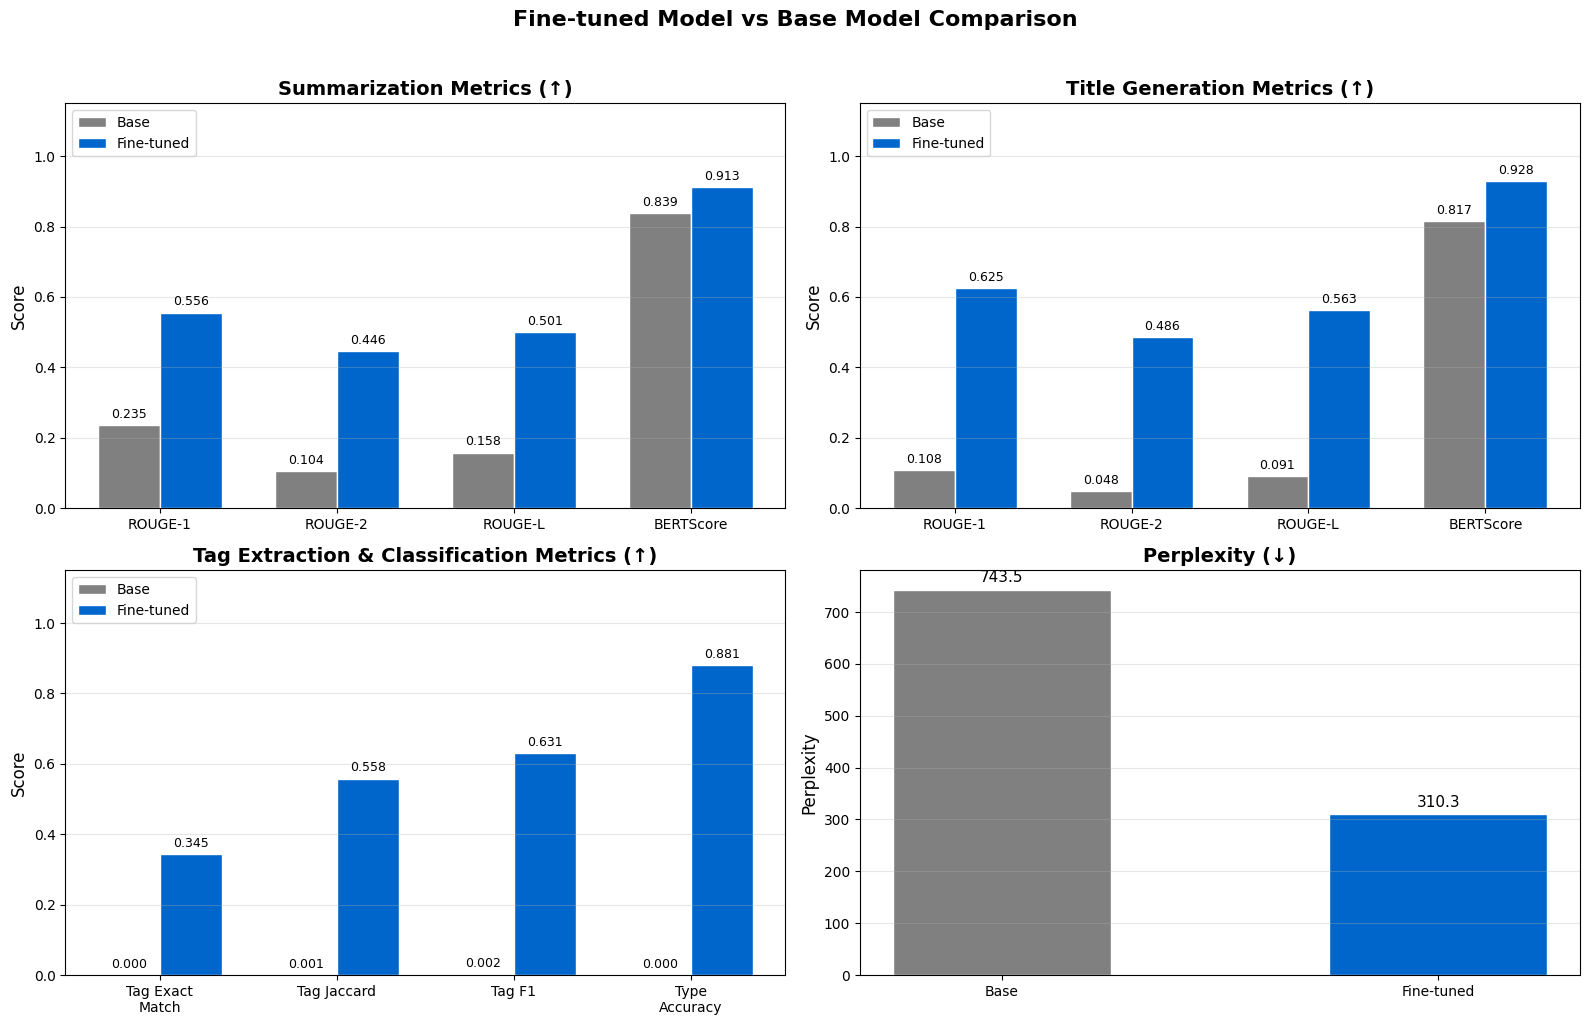

✓ Saved: ../checkpoints/unsloth/Llama-3.2-1B-Instruct/model_comparison_all_metrics.png


In [27]:
# =============================================================================
# Visualization: Side-by-Side Comparison - All Metrics (2x2 Layout)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Color scheme for comparison - BMW brand colors
FINETUNED_COLOR = "#0066CC"  # BMW Blue for fine-tuned
BASE_COLOR = "#808080"       # Silver/Gray for base

bar_width = 0.35
x_offset = bar_width / 2

# 1. Summarization Metrics Comparison
ax = axes[0, 0]
if "summarization" in finetuned_metrics and "summarization" in base_metrics:
    keys = ["rouge1_fmeasure", "rouge2_fmeasure", "rougeL_fmeasure", "bertscore_f1"]
    labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore"]
    
    ft_vals = [finetuned_metrics["summarization"].get(k, 0) for k in keys]
    base_vals = [base_metrics["summarization"].get(k, 0) for k in keys]
    
    x = np.arange(len(labels))
    bars1 = ax.bar(x - x_offset, base_vals, bar_width, label='Base', color=BASE_COLOR, edgecolor='white')
    bars2 = ax.bar(x + x_offset, ft_vals, bar_width, label='Fine-tuned', color=FINETUNED_COLOR, edgecolor='white')
    
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Summarization Metrics (↑)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_ylim(0, 1.15)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar in bars1:
        ax.annotate(f'{bar.get_height():.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                   xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        ax.annotate(f'{bar.get_height():.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                   xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# 2. Title Generation Metrics Comparison
ax = axes[0, 1]
if "title_generation" in finetuned_metrics and "title_generation" in base_metrics:
    keys = ["rouge1_fmeasure", "rouge2_fmeasure", "rougeL_fmeasure", "bertscore_f1"]
    labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore"]
    
    ft_vals = [finetuned_metrics["title_generation"].get(k, 0) for k in keys]
    base_vals = [base_metrics["title_generation"].get(k, 0) for k in keys]
    
    x = np.arange(len(labels))
    bars1 = ax.bar(x - x_offset, base_vals, bar_width, label='Base', color=BASE_COLOR, edgecolor='white')
    bars2 = ax.bar(x + x_offset, ft_vals, bar_width, label='Fine-tuned', color=FINETUNED_COLOR, edgecolor='white')
    
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Title Generation Metrics (↑)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_ylim(0, 1.15)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar in bars1:
        ax.annotate(f'{bar.get_height():.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                   xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        ax.annotate(f'{bar.get_height():.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                   xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# 3. Tag Extraction & Type Classification Comparison (Combined)
ax = axes[1, 0]
task_labels = []
ft_values = []
base_values = []

if "tag_extraction" in finetuned_metrics and "tag_extraction" in base_metrics:
    task_labels.extend(["Tag Exact\nMatch", "Tag Jaccard", "Tag F1"])
    ft_values.extend([
        finetuned_metrics["tag_extraction"].get("exact_match_accuracy", 0),
        finetuned_metrics["tag_extraction"].get("jaccard_similarity", 0),
        finetuned_metrics["tag_extraction"].get("f1", 0)
    ])
    base_values.extend([
        base_metrics["tag_extraction"].get("exact_match_accuracy", 0),
        base_metrics["tag_extraction"].get("jaccard_similarity", 0),
        base_metrics["tag_extraction"].get("f1", 0)
    ])

if "type_classification" in finetuned_metrics and "type_classification" in base_metrics:
    task_labels.append("Type\nAccuracy")
    ft_values.append(finetuned_metrics["type_classification"].get("accuracy", 0))
    base_values.append(base_metrics["type_classification"].get("accuracy", 0))

x = np.arange(len(task_labels))
bars1 = ax.bar(x - x_offset, base_values, bar_width, label='Base', color=BASE_COLOR, edgecolor='white')
bars2 = ax.bar(x + x_offset, ft_values, bar_width, label='Fine-tuned', color=FINETUNED_COLOR, edgecolor='white')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Tag Extraction & Classification Metrics (↑)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(task_labels, fontsize=10)
ax.set_ylim(0, 1.15)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

for bar in bars1:
    ax.annotate(f'{bar.get_height():.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
               xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.annotate(f'{bar.get_height():.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
               xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# 4. Perplexity Comparison (lower is better)
ax = axes[1, 1]
if "perplexity" in finetuned_metrics and "perplexity" in base_metrics:
    ft_ppl = finetuned_metrics["perplexity"].get("perplexity", 0)
    base_ppl = base_metrics["perplexity"].get("perplexity", 0)
    
    labels = ["Base", "Fine-tuned"]
    values = [base_ppl, ft_ppl]
    colors = [BASE_COLOR, FINETUNED_COLOR]
    
    bars = ax.bar(labels, values, color=colors, edgecolor='white', width=0.5)
    ax.set_ylabel('Perplexity', fontsize=12)
    ax.set_title('Perplexity (↓)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar in bars:
        ax.annotate(f'{bar.get_height():.1f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                   xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=11)
    
    # Add improvement annotation
    # if base_ppl > 0:
    #     pct_improvement = ((base_ppl - ft_ppl) / base_ppl) * 100
    #     ax.text(0.5, 0.85, f'Improvement: {pct_improvement:.1f}%', transform=ax.transAxes,
    #             ha='center', va='center', fontsize=12, fontweight='bold',
    #             color=FINETUNED_COLOR if pct_improvement > 0 else BASE_COLOR,
    #             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Fine-tuned Model vs Base Model Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, "model_comparison_all_metrics.png"), dpi=1000, bbox_inches="tight")
plt.show()
print(f"✓ Saved: {CHECKPOINT_DIR}/model_comparison_all_metrics.png")


In [19]:
# =============================================================================
# Final Summary: Key Findings
# =============================================================================

print("=" * 80)
print("📊 FINAL SUMMARY: Fine-tuned vs Base Model Performance")
print("=" * 80)

# Calculate overall improvements
def calc_improvement(task, metric, higher_is_better=True):
    ft = finetuned_metrics.get(task, {}).get(metric, 0)
    base = base_metrics.get(task, {}).get(metric, 0)
    diff = ft - base
    pct = ((ft - base) / abs(base) * 100) if base != 0 else 0
    if not higher_is_better:
        pct = -pct
    return ft, base, diff, pct

print("\n📈 SUMMARIZATION:")
ft, base, diff, pct = calc_improvement("summarization", "rouge1_fmeasure")
print(f"   ROUGE-1 F1:   Fine-tuned={ft:.4f}, Base={base:.4f}, Diff={diff:+.4f} ({pct:+.1f}%)")
ft, base, diff, pct = calc_improvement("summarization", "bertscore_f1")
print(f"   BERTScore F1: Fine-tuned={ft:.4f}, Base={base:.4f}, Diff={diff:+.4f} ({pct:+.1f}%)")

print("\n📝 TITLE GENERATION:")
ft, base, diff, pct = calc_improvement("title_generation", "rouge1_fmeasure")
print(f"   ROUGE-1 F1:   Fine-tuned={ft:.4f}, Base={base:.4f}, Diff={diff:+.4f} ({pct:+.1f}%)")
ft, base, diff, pct = calc_improvement("title_generation", "bertscore_f1")
print(f"   BERTScore F1: Fine-tuned={ft:.4f}, Base={base:.4f}, Diff={diff:+.4f} ({pct:+.1f}%)")

print("\n🏷️ TAG EXTRACTION:")
ft, base, diff, pct = calc_improvement("tag_extraction", "exact_match_accuracy")
print(f"   Exact Match:  Fine-tuned={ft:.4f}, Base={base:.4f}, Diff={diff:+.4f} ({pct:+.1f}%)")
ft, base, diff, pct = calc_improvement("tag_extraction", "f1")
print(f"   F1 Score:     Fine-tuned={ft:.4f}, Base={base:.4f}, Diff={diff:+.4f} ({pct:+.1f}%)")

print("\n🏷️ TYPE CLASSIFICATION:")
ft, base, diff, pct = calc_improvement("type_classification", "accuracy")
print(f"   Accuracy:     Fine-tuned={ft:.4f}, Base={base:.4f}, Diff={diff:+.4f} ({pct:+.1f}%)")

print("\n📉 PERPLEXITY (Lower is Better):")
ft, base, diff, pct = calc_improvement("perplexity", "perplexity", higher_is_better=False)
print(f"   Perplexity:   Fine-tuned={ft:.2f}, Base={base:.2f}, Diff={diff:+.2f} ({pct:+.1f}% improvement)")

# Count improvements
improved = 0
total = 0
for task, metric, _, higher_is_better in [
    ("summarization", "rouge1_fmeasure", "ROUGE-1", True),
    ("summarization", "rouge2_fmeasure", "ROUGE-2", True),
    ("summarization", "rougeL_fmeasure", "ROUGE-L", True),
    ("summarization", "bertscore_f1", "BERTScore", True),
    ("title_generation", "rouge1_fmeasure", "ROUGE-1", True),
    ("title_generation", "rouge2_fmeasure", "ROUGE-2", True),
    ("title_generation", "rougeL_fmeasure", "ROUGE-L", True),
    ("title_generation", "bertscore_f1", "BERTScore", True),
    ("tag_extraction", "exact_match_accuracy", "Exact Match", True),
    ("tag_extraction", "f1", "F1", True),
    ("type_classification", "accuracy", "Accuracy", True),
    ("perplexity", "perplexity", "Perplexity", False),
]:
    ft = finetuned_metrics.get(task, {}).get(metric, 0)
    base = base_metrics.get(task, {}).get(metric, 0)
    total += 1
    if higher_is_better and ft > base:
        improved += 1
    elif not higher_is_better and ft < base:
        improved += 1

print("\n" + "=" * 80)
print(f"🎯 OVERALL: Fine-tuned model improved on {improved}/{total} metrics ({improved/total*100:.1f}%)")
print("=" * 80)


📊 FINAL SUMMARY: Fine-tuned vs Base Model Performance

📈 SUMMARIZATION:
   ROUGE-1 F1:   Fine-tuned=0.5557, Base=0.2350, Diff=+0.3207 (+136.5%)
   BERTScore F1: Fine-tuned=0.9127, Base=0.8390, Diff=+0.0737 (+8.8%)

📝 TITLE GENERATION:
   ROUGE-1 F1:   Fine-tuned=0.6253, Base=0.1078, Diff=+0.5174 (+479.9%)
   BERTScore F1: Fine-tuned=0.9283, Base=0.8167, Diff=+0.1116 (+13.7%)

🏷️ TAG EXTRACTION:
   Exact Match:  Fine-tuned=0.3448, Base=0.0000, Diff=+0.3448 (+0.0%)
   F1 Score:     Fine-tuned=0.6307, Base=0.0018, Diff=+0.6289 (+34557.9%)

🏷️ TYPE CLASSIFICATION:
   Accuracy:     Fine-tuned=0.8811, Base=0.0000, Diff=+0.8811 (+0.0%)

📉 PERPLEXITY (Lower is Better):
   Perplexity:   Fine-tuned=310.28, Base=743.48, Diff=-433.20 (+58.3% improvement)

🎯 OVERALL: Fine-tuned model improved on 12/12 metrics (100.0%)


In [20]:
# =============================================================================
# Qualitative Comparison: Sample Outputs
# =============================================================================

print("=" * 80)
print("📝 QUALITATIVE COMPARISON: Sample Outputs")
print("=" * 80)

# Show a few examples comparing fine-tuned vs base model outputs
num_examples = 3

for i in range(min(num_examples, len(results))):
    ft_result = results[i]
    base_result = base_results[i]
    
    print(f"\n{'='*80}")
    print(f"Example {i+1}")
    print(f"{'='*80}")
    
    # Truncate user message for display
    user_msg = ft_result["user_message"]
    if len(user_msg) > 300:
        user_msg = user_msg[:300] + "..."
    print(f"\n📝 User Message:\n{user_msg}")
    
    print(f"\n✅ Expected Output:\n{ft_result['expected']}")
    
    print(f"\n🔵 Fine-tuned Model Output:\n{ft_result['generated']}")
    
    print(f"\n🟠 Base Model Output:\n{base_result['generated']}")
    
    print(f"\n{'─'*80}")


📝 QUALITATIVE COMPARISON: Sample Outputs

Example 1

📝 User Message:
Summarize the following BMW news article in a concise way.

There's something magical about waking up in Namibia, even more so when it's under the roar of lions, ready for battle - or at least, that's what it felt like listening to the nearly 80 boxer engines revving up as they emerged from the vall...

✅ Expected Output:
Recap of Day 2. Location: Spitzkoppe, Namibia Weather: Sunny, 12°C – 29 °C Course: 184km: Ai Aiba – Schwarze Spitzkoppe – Spitzkoppe Terrain types: Tarmac 0km, off-road 184km Tests: SP1: Flying Boxer, SP2: The SENA Rock Challenge Top three teams male: 1. South Africa, 2. Germany, 3. International Team Top three teams female: 1. Germany, Japan, 3. Benelux

🔵 Fine-tuned Model Output:
On 4th and 5th March 2024, riders from 9 countries took on the diverse landscapes of Namibia in the BMW Motorrad International GS Trophy 2024.

🟠 Base Model Output:
Here's a concise summary of the BMW news article:

**BMW 